In [34]:
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

In [80]:
train =  pd.read_csv('../data/train/train.csv')
train.rename(columns={train.columns[0]: 'date'}, inplace=True)
train = train.dropna().copy()
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%y')
train.set_index('date', inplace=True)
train = train.asfreq('MS')
train = train['y']

In [81]:
print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(train)
kpss_result = kpss(train)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -6.156134883240396, p-value: 7.36098813916681e-08
KPSS Statistic: 0.5219510640942964, p-value: 0.03672273331209541


In [82]:
train_diff = train.diff().dropna()
print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(train_diff)
kpss_result = kpss(train.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -5.958267200771968, p-value: 2.0682223877773172e-07
KPSS Statistic: 0.08758619270101767, p-value: 0.1


C:\Users\Usuario\AppData\Local\Temp\ipykernel_24008\2614224081.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(train.diff().dropna())


<Axes: title={'center': 'Diferenciación orden 1'}, xlabel='date'>

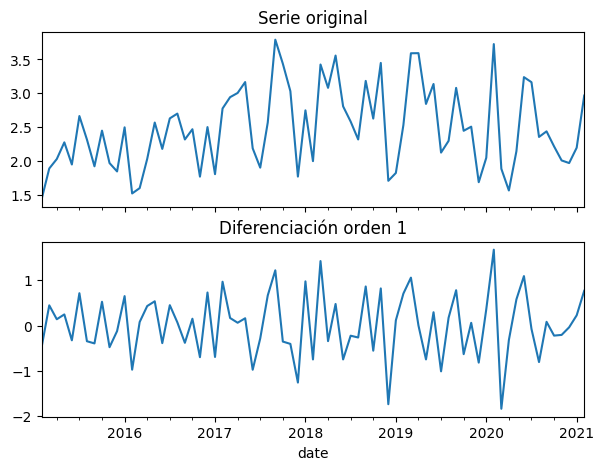

In [83]:
# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)
train.plot(ax=axs[0], title='Serie original')
train_diff.plot(ax=axs[1], title='Diferenciación orden 1')

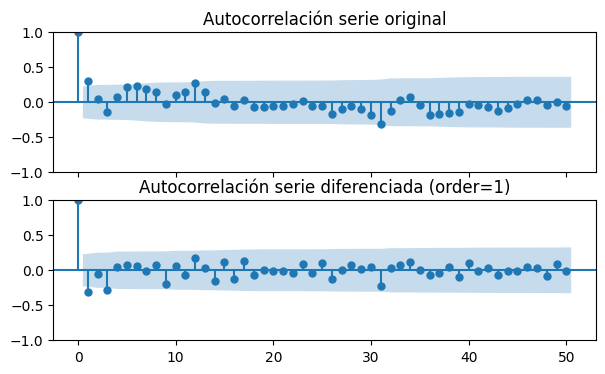

In [84]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(train, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(train_diff, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

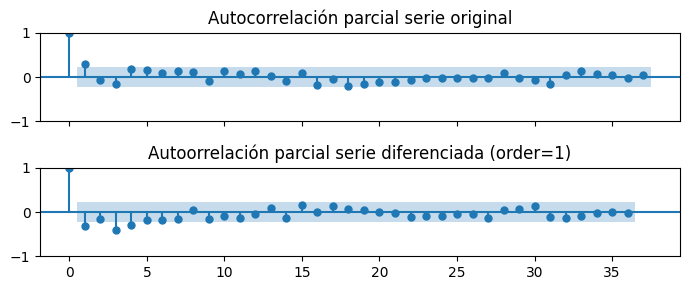

In [85]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(train, ax=axs[0], lags=37, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(train_diff, ax=axs[1], lags=36, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

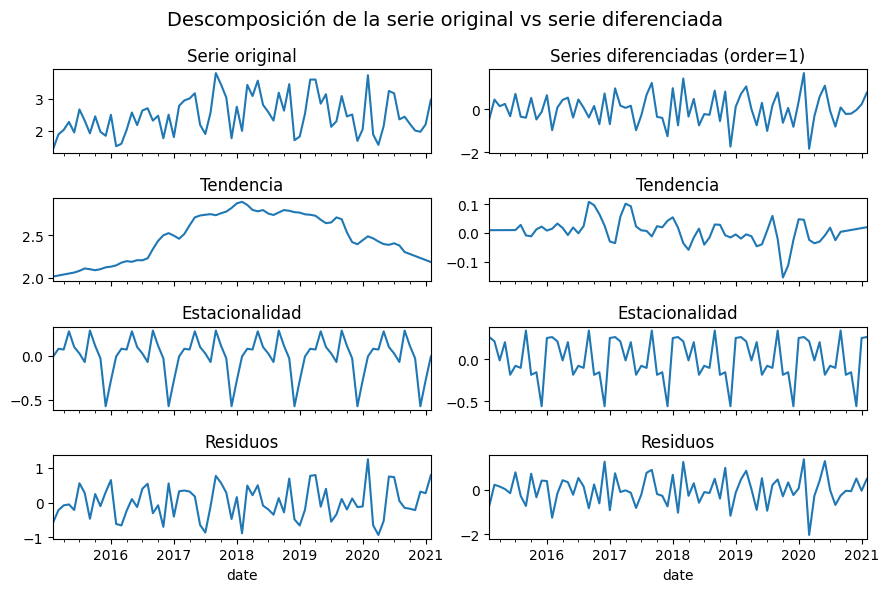

In [86]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose = seasonal_decompose(train, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(train_diff, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos')
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

In [87]:
test = train.tail(4).copy()
train_2 = train.drop(train.tail(4).index)

In [88]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
modelo = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=train_2)
modelo.summary()

C:\Users\Usuario\AppData\Local\Programs\Python\envs\between\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   70
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -58.462
Date:                            Sun, 17 Mar 2024   AIC                            126.923
Time:                                    11:57:15   BIC                            137.138
Sample:                                01-01-2015   HQIC                           130.893
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1130      0.123      0.917      0.359      -0.129       0.355
ma.L1         -0.8945      0.085    -10.560      0.000      -1.060      -0.728
ar.S.L12       0.3434      0.550      0.625      0.532      -0.734       1.421
ma.S.L12      -0.9922     18.149     -0.055      0.956     -36.563      34.578
sigma2         0.3461      6.145      0.056      0.955     -11.697      12.389
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.95   Prob(JB):                         0.97
Heteroskedasticity (H):               2.18   Skew:                             0.03
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
# Predictión
# ==============================================================================
predicciones_skforecast = modelo.predict(steps=len(test))
display(predicciones_skforecast.head(6))

,pred
2020-11-01,2.421699
2020-12-01,1.770538
2021-01-01,2.104734
2021-02-01,2.847853


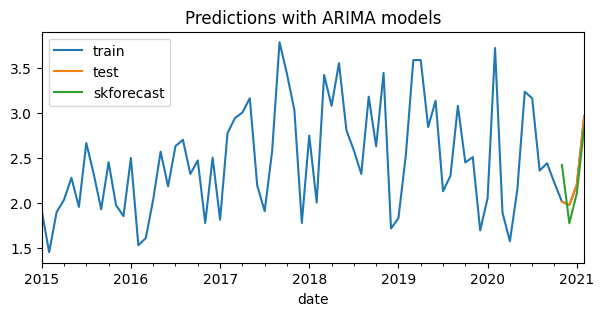

In [90]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
predicciones_skforecast.columns = ['skforecast']
predicciones_skforecast.plot(ax=ax, label='skforecast')
ax.set_title('Predictions with ARIMA models')
ax.legend();

In [93]:
# Modelo ARIMA con ForecasterSarimax y skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=train, suppress_warnings=True)

In [95]:
# Predicción
predicciones = forecaster.predict(steps=12)
predicciones.head(12)

2021-03-01    2.300777
2021-04-01    2.168865
2021-05-01    2.521668
2021-06-01    2.833208
2021-07-01    2.798374
2021-08-01    2.419476
2021-09-01    2.635437
2021-10-01    2.472608
2021-11-01    2.283956
2021-12-01    1.958907
2022-01-01    2.227718
2022-02-01    2.661076
Freq: MS, Name: pred, dtype: float64

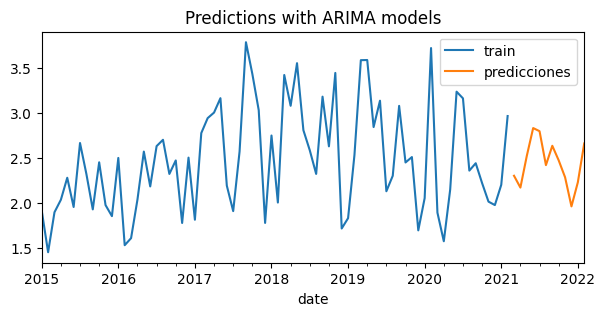

In [98]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
train.plot(ax=ax, label='train')
predicciones.plot(ax=ax, label='predicciones')
ax.set_title('Predictions with ARIMA models')
ax.legend();